# Using a Multiple Linear Regression Classifier on the Gapminder Dataset to Predict Life Expectancy

In this program we will use features in the Gapminder dataset such as fertility, Gross Domestic Product (GDP), Body Mass Index (BMI), and child mortality to predict life expectancy. Each row in the dataset represents the data for a country. A linear regression classifier is the obvious choice for a predictive model when the target variable (life expectancy) is continuous. 

We begin by importing the data and checking for missing values.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

# read the data into a Pandas data frame
df = pd.read_csv('Gapminder.csv')
# shuffle data before use with sklearn
df = shuffle(df)
# check for missing and nan values
print(df.isnull().sum())
print('\n')
print('Nan values present: {}'.format(df.isnull().values.any()))
# inspect first 10 rows
df.head(10)

population         0
fertility          0
HIV                0
CO2                0
BMI_male           0
GDP                0
BMI_female         0
life               0
child_mortality    0
Region             0
dtype: int64


Nan values present: False


,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality,Region
13,8973525.0,5.27,1.2,0.537539,22.41835,1646.0,130.2723,63.2,116.3,Sub-Saharan Africa
95,2652281.0,2.89,0.1,15.572080,26.24109,47799.0,126.8870,74.6,11.9,Middle East & North Africa
40,1339941.0,1.62,1.2,13.031379,26.26446,24743.0,129.5161,74.0,5.5,Europe & Central Asia
88,26325183.0,2.90,0.4,0.105413,20.76344,1866.0,125.5561,68.6,50.7,South Asia
111,4849641.0,1.28,0.1,4.114441,23.83996,65991.0,121.1736,80.9,2.8,East Asia & Pacific
23,33363256.0,1.68,0.2,16.350399,27.45210,41468.0,118.0571,80.7,5.8,America
5,8331465.0,1.41,0.3,8.183160,26.46741,43952.0,124.1394,80.4,4.6,Europe & Central Asia
119,506657.0,2.41,1.0,4.741140,25.49887,13470.0,124.6358,69.1,26.4,America
30,19261647.0,4.91,3.7,0.361897,22.56469,2854.0,131.5237,55.9,116.9,Sub-Saharan Africa
132,61689620.0,1.87,0.2,8.526467,27.39249,37739.0,124.0845,79.5,5.6,Europe & Central Asia


In [8]:
# print basic statistics
df.describe()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality
count,1.390000e+02,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000,139.000000
mean,3.549977e+07,3.005108,1.915612,4.459874,24.623054,16638.784173,126.701914,69.602878,45.097122
std,1.095121e+08,1.615354,4.408974,6.268349,2.209368,19207.299083,4.471997,9.122189,45.724667
min,2.773150e+05,1.280000,0.060000,0.008618,20.397420,588.000000,117.375500,45.200000,2.700000
25%,3.752776e+06,1.810000,0.100000,0.496190,22.448135,2899.000000,123.232200,62.200000,8.100000
50%,9.705130e+06,2.410000,0.400000,2.223796,25.156990,9938.000000,126.519600,72.000000,24.000000
75%,2.791973e+07,4.095000,1.300000,6.589156,26.497575,23278.500000,130.275900,76.850000,74.200000
max,1.197070e+09,7.590000,25.900000,48.702062,28.456980,126076.000000,135.492000,82.600000,192.000000


We will not be able to use the categorical 'Region' feature in a linear regression model so we drop it and assign the rest of the features to X, minus 'life' which is assigned as the target.

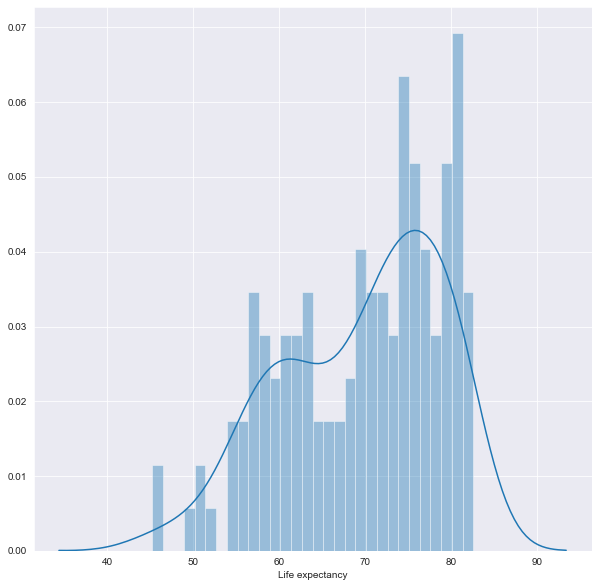

In [9]:
# assign the X and y data
X = df.drop(['life', 'Region'], axis = 1).values
y = pd.Series(df['life'], name = 'Life expectancy')

# create a distribution plot of the target
sns.set_style('darkgrid')
fig = plt.figure(figsize = (10, 10))
ax = sns.distplot(y, bins = 30)
plt.show()

The life expectancy shows a left-skewed normal distrbution.

We can produce a correlation matrix to visualise the correlations between the variables in the dataset.

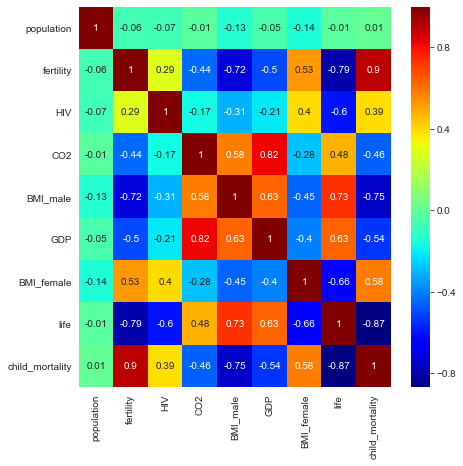

In [10]:
# create a correlation matrix that measures the relationships between the variables
correlation_matrix = df.corr().round(2)
fig = plt.figure(figsize = (7, 7))
ax = sns.heatmap(correlation_matrix, annot = True, cmap = 'jet')
# visualise the matrix
plt.show()

Male BMI and GDP are the features with the strongest positive correlation with life expectancy, whereas child mortality and fertility are the features with the strongest negative correlation. There also appears to be collinearity between child mortality and fertility, and GDP and CO2. If model performance is not satisfactory we will have to address this issue. 

The values of the different features vary by many orders of magnitude, so it is crucial that we scale the features if we are using regularisation. We will use StandardScaler which computes the z-score according to $$Z = \frac{x - \mu}{\sigma}$$ where $x$ is the observed value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.

Elastic Net regularisation (E) employs a linear combination of lasso (L1) and ridge (L2) regularisation, i.e., $E = aL1 + bL2$, where $a$ and $b$ are constants. The L1 ratio corresponds to $a/(a+b)$: an L1 ratio of one is equal to lasso regression, a ratio of zero is equal to ridge regression, and anything in between is a combination of the two.
The regularised linear regression cost function utilises the regularisation parameter $\alpha$. Sklearn makes use of the same parameter, where $\alpha = a+b$ in elastic net regularisation.
We are going to generate an elastic net estimator and grids of the L1 ratio and $\alpha$ to perform a grid search over. Via this method we can identify the best type of regularisation and $\alpha$ for the model.

Although not necessary with such a small dataset, we will employ a pipeline which enhances computational efficiency. We define the steps the pipeline is to make and pass them to the pipeline object. Then we create hyperparameter grids for the L1 ratio and $\alpha$, and use GridSearchCV to perform a cross-validated grid search and identify the optimal values.

In [11]:
# setup the pipeline steps
steps = [('scaler', StandardScaler()), ('elasticnet', ElasticNet())]
# create the pipeline
pipeline = Pipeline(steps)
# specify the hyperparameter spaces
parameters = {'elasticnet__l1_ratio': np.linspace(0, 1, 30), 'elasticnet__alpha': np.logspace(-2, 2, 30)}
# create the GridSearchCV object to find the optimum l1 ratio and alpha value
lin_reg_cv = GridSearchCV(pipeline, parameters, cv = 5)
# fit to the data
lin_reg_cv.fit(X, y)
# compute the R^2 metric
r2 = lin_reg_cv.best_score_
print("Tuned ElasticNet Alpha: {}".format(lin_reg_cv.best_params_))
print("Tuned ElasticNet R squared: {:.2f}".format(r2))

Tuned ElasticNet Alpha: {'elasticnet__alpha': 0.04893900918477494, 'elasticnet__l1_ratio': 0.41379310344827586}
Tuned ElasticNet R squared: 0.88


The cross-validated grid search selects a linear combination of ridge and lasso regularisation with a very small $\alpha$.

Linear regression uses the coefficient of determination, $R^2$ to measure model performance. It is defined as the proportion of variance in the dependent variable that is predictable from the independent variables. The coefficient of determination normally ranges from zero to one, with a value of one representing the model perfectly fitting the data.

For a multiple linear regression model we should use the adjusted coefficient of determination $\hat{R^2}$, which is defined as $$\hat{R^2} = 1 - (1-R^2)\frac{(n-1)}{(n-p-1)}$$
where $n$ is the number of samples, $R$ is the standard coefficient of determination and $p$ is the number of features.

In [12]:
def adj_r2(r_squared, X):
    n, p = X.shape
    return 1 - (1 - r_squared)*((n - 1)/(n - p - 1))

print('Adjusted R^2 score for multiple linear regression: {:.2f}'.format(adj_r2(lin_reg_cv.best_score_, X)))

Adjusted R^2 score for multiple linear regression: 0.87
